In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'retina'
%reload_ext snakeviz
%reload_ext line_profiler

In [2]:
import pandas as pd
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt

import logging
logging.basicConfig(level=logging.INFO)

In [3]:
from collections import namedtuple
from os.path import join, abspath, dirname, pardir

# LFP sampling frequency
sampling_frequency = 1500

# Data directories and definitions
NOTEBOOK_DIR = !pwd
ROOT_DIR = abspath(dirname(NOTEBOOK_DIR[0]))
RAW_DATA_DIR = join(ROOT_DIR, 'Raw-Data')

Animal = namedtuple('Animal', {'directory', 'short_name'})
animals = {
    'bon': Animal(directory=join(RAW_DATA_DIR, 'Bond'),
                  short_name='bon'),
}

epoch_key = ('bon', 3, 2)

In [4]:
from logging import getLogger
from os.path import join

from loren_frank_data_processing import (get_all_multiunit_indicators,
                                         get_all_spike_indicators,
                                         get_interpolated_position_dataframe,
                                         get_LFPs, make_neuron_dataframe,
                                         make_tetrode_dataframe)
from ripple_detection import (Kay_ripple_detector, filter_ripple_band,
                              get_multiunit_population_firing_rate,
                              multiunit_HSE_detector)
from spectral_connectivity import Connectivity, Multitaper
from scipy.ndimage.measurements import label
from matplotlib.colors import ListedColormap, LogNorm
import seaborn as sns

logger = getLogger(__name__)

_MARKS = ['channel_1_max', 'channel_2_max', 'channel_3_max', 'channel_4_max']


def get_ripple_labels(ripple_times, time):
    ripple_labels = pd.DataFrame(np.zeros_like(time, dtype=np.int), index=time,
                                 columns=['replay_number'])
    for replay_number, start_time, end_time in ripple_times.itertuples():
        ripple_labels.loc[start_time:end_time] = replay_number

    return ripple_labels


def estimate_ripple_band_power(lfps, sampling_frequency):
    m = Multitaper(lfps.values, sampling_frequency=sampling_frequency,
                   time_halfbandwidth_product=1,
                   time_window_duration=0.020,
                   time_window_step=0.020,
                   start_time=lfps.index[0].total_seconds())
    c = Connectivity.from_multitaper(m)
    closest_200Hz_freq_ind = np.argmin(np.abs(c.frequencies - 200))
    power = c.power()[..., closest_200Hz_freq_ind, :].squeeze() + np.spacing(1)
    n_samples = int(0.020 * sampling_frequency)
    index = lfps.index[np.arange(1, power.shape[0] * n_samples + 1, n_samples)]
    power = pd.DataFrame(power, index=index)
    return power.reindex(lfps.index)


def load_data(epoch_key, animals, sampling_frequency, data_types,
              brain_areas, speed_metric='linear_speed'):

    logger.info('Loading Data...')
    position_info = (
        get_interpolated_position_dataframe(epoch_key, animals)
        .dropna(subset=['linear_distance', 'linear_speed']))

    speed = position_info[speed_metric]
    time = position_info.index

    tetrode_info = make_tetrode_dataframe(animals).xs(
        epoch_key, drop_level=False)
    is_brain_areas = tetrode_info.area.isin(brain_areas)
    tetrode_keys = tetrode_info.loc[
        (tetrode_info.validripple == 1) & is_brain_areas].index
    lfps = get_LFPs(tetrode_keys, animals)
    lfps = lfps.reindex(time)

    if 'lfp_power' in data_types:
        power = estimate_ripple_band_power(lfps, sampling_frequency)
    else:
        power = None

    neuron_info = make_neuron_dataframe(animals).xs(
        epoch_key, drop_level=False)
    neuron_info = neuron_info.loc[
        (neuron_info.numspikes > 0) &
        neuron_info.area.isin(brain_areas)]
    spikes = (get_all_spike_indicators(neuron_info.index, animals)
              .reindex(time))

    logger.info('Finding multiunit high synchrony events...')
    tetrode_info = tetrode_info.loc[
        (tetrode_info.numcells > 0) & is_brain_areas]
    if 'multiunit' in data_types:
        multiunit = (get_all_multiunit_indicators(tetrode_info.index, animals)
                     .sel(features=_MARKS)
                     .reindex({'time': time}))
        multiunit_spikes = (np.any(~np.isnan(multiunit), axis=1)
                            .values).astype(np.float)
        multiunit_high_synchrony_times = multiunit_HSE_detector(
            time, multiunit_spikes, speed.values, sampling_frequency,
            minimum_duration=np.timedelta64(15, 'ms'), zscore_threshold=2.0,
            close_event_threshold=np.timedelta64(0, 'ms'))
        multiunit_high_synchrony_times.index = (
            multiunit_high_synchrony_times.index.rename('replay_number'))
        multiunit_high_synchrony_labels = get_ripple_labels(
            multiunit_high_synchrony_times, time)
        multiunit_firing_rate = pd.DataFrame(
            get_multiunit_population_firing_rate(
                multiunit_spikes, sampling_frequency), index=time,
            columns=['firing_rate'])
    else:
        multiunit = None
        multiunit_high_synchrony_times = None
        multiunit_high_synchrony_labels = 0
        multiunit_firing_rate = None

    logger.info('Finding ripple times...')
    ripple_times = Kay_ripple_detector(
        time, lfps.values, speed.values, sampling_frequency,
        zscore_threshold=2.0, close_ripple_threshold=np.timedelta64(0, 'ms'),
        minimum_duration=np.timedelta64(15, 'ms'))
    ripple_times.index = ripple_times.index.rename('replay_number')
    ripple_labels = get_ripple_labels(ripple_times, time)

    ripple_band_lfps = pd.DataFrame(
        np.stack([filter_ripple_band(lfps.values[:, ind])
                  for ind in np.arange(lfps.shape[1])], axis=1),
        index=lfps.index)

    ripple_times = ripple_times.assign(
        duration=lambda df: (df.end_time - df.start_time).dt.total_seconds())

    return {
        'position_info': position_info,
        'ripple_times': ripple_times,
        'is_ripple': ripple_labels > 0,
        'ripple_labels': ripple_labels,
        'power': power,
        'spikes': spikes,
        'multiunit': multiunit,
        'lfps': lfps,
        'tetrode_info': tetrode_info,
        'ripple_band_lfps': ripple_band_lfps,
        'multiunit_high_synchrony_times': multiunit_high_synchrony_times,
        'is_multiunit_high_synchrony': multiunit_high_synchrony_labels > 0,
        'multiunit_firing_rate': multiunit_firing_rate,
    }



def start_time(s):
    return s.index[0]


def end_time(s):
    return s.index[-1]


def max_probability(df):
    return df.max()


def duration(df):
    return (df.index[-1] - df.index[0]).total_seconds()

def get_replay_times(results, probability_threshold=0.8,
                     minimum_duration=0.000):

    replay_labels = label(
        results.replay_probability > probability_threshold)[0]
    labels = pd.DataFrame(
        {'replay_number': replay_labels,
         'replay_probability': results.replay_probability.values},
        index=results.time.to_index())

    grouper = labels.loc[labels.replay_number > 0].groupby('replay_number')
    replay_times = (grouper
                    .agg([start_time, end_time, duration, max_probability]))
    replay_times.columns = replay_times.columns.get_level_values(1)

    replay_times = replay_times.loc[replay_times.duration > minimum_duration]
    labels[~labels.isin(replay_times.index.values)] = 0

    return replay_times, labels

In [5]:
data_types = {'multiunit'}
brain_areas = ['CA1', 'CA2', 'CA3']

data = load_data(epoch_key, animals, sampling_frequency, data_types,
                 brain_areas, speed_metric='linear_speed')

INFO:__main__:Loading Data...
INFO:__main__:Finding multiunit high synchrony events...
INFO:__main__:Finding ripple times...


In [20]:
from replay_trajectory_classification import ClusterlessClassifier
from replay_trajectory_classification.misc import NumbaKDE

# Classifier Parameters
place_bin_size = 3.0
movement_var = 6.0
replay_speed = 1
model = NumbaKDE
model_kwargs = {
    'bandwidth': np.array([24.0, 24.0, 24.0, 24.0, 5.0, 5.0])
}
knot_spacing = 5
spike_model_penalty = 0.5
discrete_diag = 0.98
continuous_transition_types = (
    [['w_track_1D_random_walk', 'uniform', 'identity'],  # noqa
     ['uniform',                'uniform', 'uniform'],   # noqa
     ['w_track_1D_random_walk', 'uniform', 'identity']])  # noqa


classifier = ClusterlessClassifier(
    place_bin_size=place_bin_size,
    movement_var=movement_var,
    replay_speed=replay_speed,
    discrete_transition_diag=discrete_diag,
    continuous_transition_types=continuous_transition_types,
    model=model,
    model_kwargs=model_kwargs,
)

classifier

ClusterlessClassifier(continuous_transition_types=[['w_track_1D_random_walk',
                                                    'uniform', 'identity'],
                                                   ['uniform', 'uniform',
                                                    'uniform'],
                                                   ['w_track_1D_random_walk',
                                                    'uniform', 'identity']],
                      discrete_transition_diag=0.98,
                      discrete_transition_type='strong_diagonal',
                      infer_track_interior=True,
                      initial_conditions_type='uniform_on_track',
                      model=<class 'replay_trajectory_classification.misc.NumbaKDE'>,
                      model_kwargs={'bandwidth': array([24., 24., 24., 24.,  5.,  5.])},
                      movement_var=6.0,
                      occupancy_kwargs={'bandwidth': array([24., 24., 24., 24.,  5.,  5.])},
           

In [21]:
is_training = data["position_info"].speed > 4
position = data["position_info"].loc[:, "linear_position"]
track_labels = data["position_info"].arm_name

In [22]:
%%snakeviz -t

classifier.fit(position, data["multiunit"], is_training=is_training, track_labels=track_labels)

INFO:replay_trajectory_classification.classifier:Fitting initial conditions...
INFO:replay_trajectory_classification.classifier:Fitting state transition...
INFO:replay_trajectory_classification.classifier:Fitting multiunits...


 
*** Profile stats marshalled to file '/tmp/tmpogtd6ar4'. 
Opening SnakeViz in a new tab...


In [27]:
%%snakeviz -t

results = classifier.predict(data['multiunit'].isel(time=slice(10_000, 20_000)))

 
*** Profile stats marshalled to file '/tmp/tmpuw6ivz8l'. 
Opening SnakeViz in a new tab...


In [28]:
results

<xarray.Dataset>
Dimensions:            (position: 107, state: 3, time: 10000)
Coordinates:
  * time               (time) int64 0 1 2 3 4 5 ... 9995 9996 9997 9998 9999
  * position           (position) float64 1.493 4.478 7.463 ... 314.9 317.9
  * state              (state) <U22 'w_track_1D_random_walk' ... 'identity'
Data variables:
    likelihood         (time, state, position) float64 0.9848 0.9609 ... 0.6915
    causal_posterior   (time, state, position) float64 0.00537 ... 0.0002274
    acausal_posterior  (time, state, position) float64 0.01684 ... 0.0002274

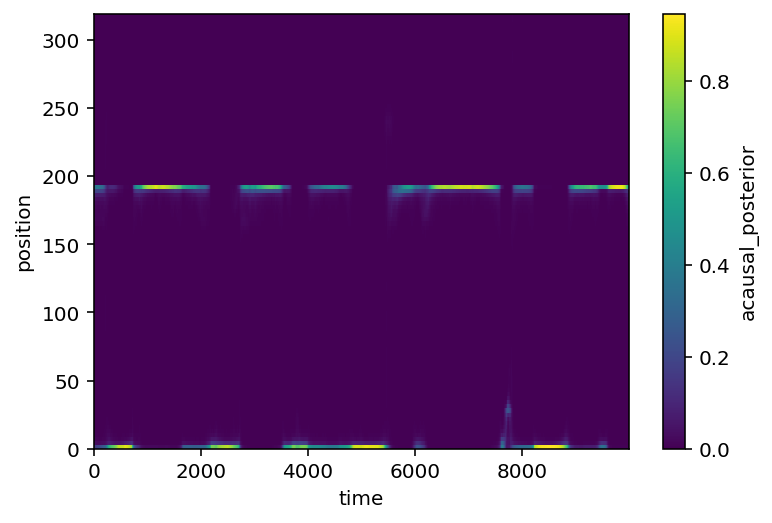

In [29]:
results['acausal_posterior'].sum('state').plot(x='time', y='position')